# To-Do
- ~~rerun flows from 1981 as start date~~
- ~~cast features as category dtype before training catboost~~
- ~~engineer categorical features from 'number_of_outings_in_last_year' and 'trip_fishing_effort_hours'~~
- ~~re-evaluate models after adding new features -> look at feature importance on catboost model~~
- ~~naive bayes outperforming catboost~~
- ~~waterfall plot on CategoricalNB - inverse transform not working~~
- ~~single observation force plot on CatBoost not working - needed iloc because X test is pandas dataframe not numpy array~~
- SHAP - use sample sizes for all, check how sampling works (selecting first X samples?)
- look at interactions on both models
- pipreqs to update requirements.txt

In [1]:
import duckdb
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from catboost import CatBoostClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score

shap.initjs()

In [2]:
#constants
SCHEMA = 'analytics'
DUCKDB_PATH = str(Path().resolve().parent / "data/noaa_dw.duckdb")

In [3]:
#Database Connection and Query
with duckdb.connect(DUCKDB_PATH) as con:
    query = f"""
            SELECT
            fish_caught_time_of_day,
            trip_month_name,
            fishing_season,
            us_region,
            nautical_zone,
            fishing_method_collapsed,
            number_of_outings_in_last_year,
            number_of_outings_in_last_2_months,
            trip_fishing_effort_hours,
            caught
            FROM
            {SCHEMA}.trip_details
            """
    df = con.sql(query).df() #materialize into pandas dataframe

### Preprocessing

In [4]:
df = df.dropna() #drop any rows that have NaNs

In [5]:
# Feature Engineering
def get_annual_outing_frequency(number_of_annual_outings):
    if number_of_annual_outings == 0:
        return 'Rarely (First Outing)'
    elif number_of_annual_outings <= 50:
        return 'Sometimes (<= 50x/year)'
    elif number_of_annual_outings <= 100:
        return 'Often (50-100x/year)'
    else:
        return 'Very Often (> 100x/year)'

def get_bimonthly_outing_frequency(number_of_bimonthly_outings):
    if number_of_bimonthly_outings == 0:
        return 'Rarely (First Outing)'
    elif number_of_bimonthly_outings <= 5:
        return 'Sometimes (<= 5 outings)'
    elif number_of_bimonthly_outings <= 15:
        return 'Often (5-15 outings)'
    else:
        return 'Very Often (> 15 outings)'

def get_effort_rating(effort_hours):
    if effort_hours == 0:
        return 'No Effort'
    elif effort_hours <= 5:
        return 'Low (<= 5 hours)'
    elif effort_hours <= 15:
        return 'Moderate (5-15 hours)'
    else:
        return 'High (> 15 hours)'

df['annual_outing_freq'] = df['number_of_outings_in_last_year'].apply(get_annual_outing_frequency)
df['bimonthly_outing_freq'] = df['number_of_outings_in_last_2_months'].apply(get_bimonthly_outing_frequency)
df['effort_rating'] = df['trip_fishing_effort_hours'].apply(get_effort_rating)


In [6]:
def preprocess_data(df: pd.DataFrame):
    #Define Features and Label
    drop_cols = ['number_of_outings_in_last_2_months',
                'number_of_outings_in_last_year',
                'trip_fishing_effort_hours',
                'trip_month_name',
                'caught']
    X = df.drop(columns=drop_cols)
    feature_names = X.columns.tolist()
    X = X.astype('category') # cast as category dtype
    y = df['caught'].astype(int)

    return feature_names, X, y

In [7]:
def plot_learning_curve(model, X, y, cv=3, performance=None):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=cv, scoring=performance, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Mean & standard deviation
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(validation_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(validation_scores, axis=1)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mean, "o-", label="Train Score", color="blue")
    plt.plot(train_sizes, test_mean, "o-", label="Validation Score", color="orange")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="orange")

    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

    return


### EDA

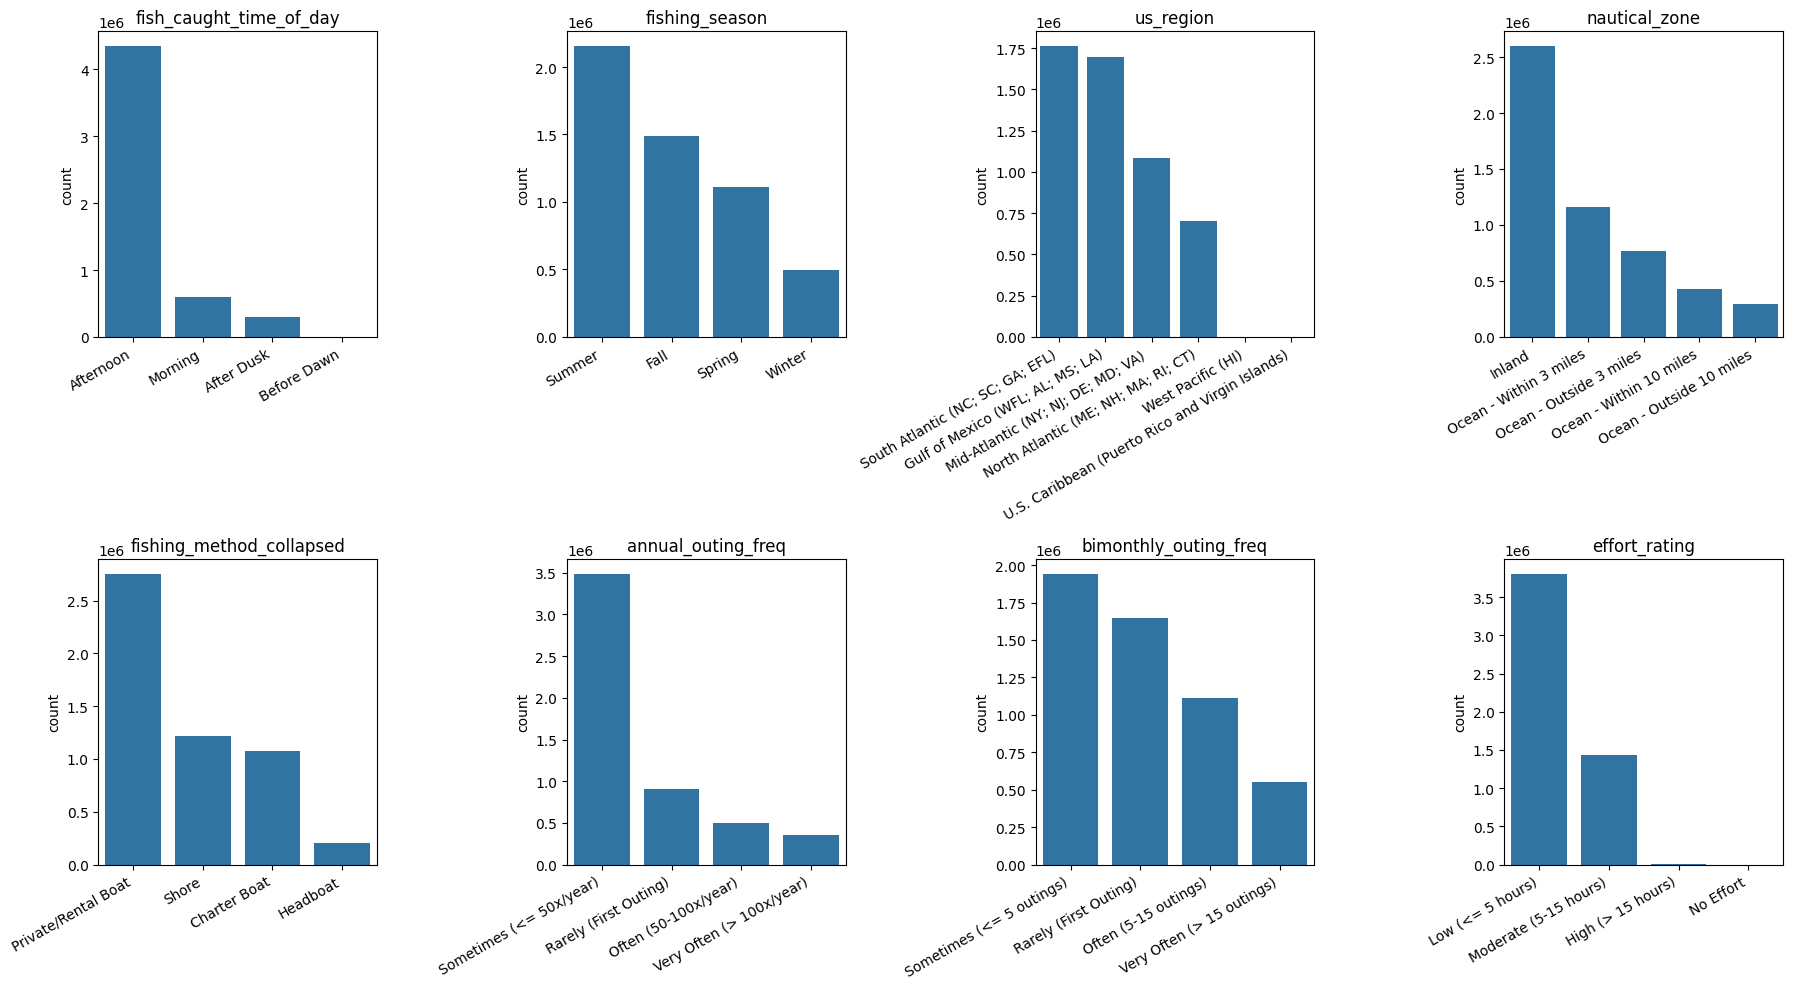

In [9]:
categorical_features = ['fish_caught_time_of_day', 'fishing_season', 'us_region',
                        'nautical_zone', 'fishing_method_collapsed', 'annual_outing_freq',
                        'bimonthly_outing_freq', 'effort_rating']


fig, axes = plt.subplots(2, 4, figsize=(18, 10))

axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i], order=df[feature].value_counts().index)
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=30, labelsize=10) 
    for label in axes[i].get_xticklabels():
        label.set_ha('right')  


plt.tight_layout()
plt.show()

### Baseline Model - Categorical Naive Bayes

In [ ]:
#Train model and predict
feature_names, X, y = preprocess_data(df)

#Encoding
encoder = OrdinalEncoder()
X = encoder.fit_transform(X)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test) #probability estimates
print("class = ", y_pred)
print("proba = ", y_proba)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


In [ ]:
# Learning Curve
plot_learning_curve(model, X, y, 3, "accuracy")

### SHAP

In [ ]:
sample_size = 10000
X_train_sample = shap.utils.sample(X_train, sample_size, random_state=42)
X_test_sample = shap.utils.sample(X_test, sample_size, random_state=42)

explainer = shap.Explainer(model.predict, X_train_sample, feature_names=feature_names)
shap_values = explainer(X_test_sample)

In [ ]:
#Feature Importance
print(shap_values)
shap.plots.bar(shap_values)

row_to_explain = 3 #expected and predicted is caught (1)
print(X_test_sample[row_to_explain], y_test[row_to_explain], y_pred[row_to_explain])
print(encoder.inverse_transform(X_test_sample)[row_to_explain])
shap.plots.waterfall(shap_values[row_to_explain])

In [ ]:
#Force plot
sample_size = 100
X_train_sample = shap.utils.sample(X_train, sample_size, random_state=42)
X_test_sample = shap.utils.sample(X_test, sample_size, random_state=42)

explainer = shap.KernelExplainer(model.predict_proba, X_train_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_sample[0])
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_sample[0])

### Alternate Model - CatBoost

In [ ]:
#Train model and predict
feature_names, X, y = preprocess_data(df)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = X_train.columns.tolist()
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           cat_features=cat_features,
                           loss_function='Logloss',
                           verbose=True)

model.fit(X_train, y_train) #fit model
y_pred = model.predict(X_test) #predict
y_proba = model.predict_proba(X_test) #probability estimates
print("class = ", y_pred)
print("proba = ", y_proba)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
print(f'Feature Importance: {dict(zip(model.feature_names_,model.get_feature_importance()))}')
print(f'{model.best_score_}')

In [ ]:
# Learning Curve
plot_learning_curve(model, X, y, 3)

### SHAP

In [ ]:
#Bar plot feature importance
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [ ]:
#Feature Importance
print(shap_values)
shap.plots.bar(shap_values)

In [ ]:
#Waterfall
row_to_explain = 3 #expected and predicted is caught (1)
print(X_test.iloc[row_to_explain], y_test[row_to_explain], y_pred[row_to_explain])
shap.plots.waterfall(shap_values[row_to_explain])

In [ ]:
sample_size = 100
X_train_sample = shap.utils.sample(X_train, sample_size, random_state=42)
X_test_sample = shap.utils.sample(X_test, sample_size, random_state=42)

#Force plot
explainer = shap.KernelExplainer(model.predict_proba, X_train_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_sample.iloc[row_to_explain])
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_sample.iloc[row_to_explain])

In [ ]:
# Interactions
sample_size = 100
X_train_sample = shap.utils.sample(X_train, sample_size, random_state=42)
X_test_sample = shap.utils.sample(X_test, sample_size, random_state=42)

shap_interaction_values = explainer.shap_interaction_values(X_test_sample)
print(shap_interaction_values[1])
shap.dependence_plot(("fishing_method_collapsed", "us_region"), shap_interaction_values, X_test_sample, feature_names=feature_names)
shap.summary_plot(shap_interaction_values[1], X_test_sample, feature_names=feature_names)


In [ ]:
print(X_train.shape)
print(X_test.shape)